# Posterior Inference using SBI

Simulation-Based Inference (SBI) with Neural Posterior Estimation (NPE) is a statistical framework for parameter inference in complex models. Instead of relying on an explicit likelihood function, NPE uses simulations to generate synthetic data and trains neural networks to learn an approximate posterior distribution of the parameters given observed data. This approach is typically used when the likelihood is intractable or expensive to compute, making traditional methods impractical. For pulse profile modelling, while the likelihood computation is tractable, sampling complex high-dimensioinal parameter spaces can get computationally expensive. SBI provides a potentially lucrative alternative to this problem.

In this example notebook, we utilize the `sbi` package to perform this. Refer to the installation instructions for additional dependencies required to run this notebook.

## Initialization

In [ ]:
## IMPORTANT: Import sequence - torch, sbi, and xpsi.
import torch
import torch.nn as nn
import torch.nn.functional as F

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.neural_nets import posterior_nn
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import prepare_for_sbi

import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
rc = {"font.family" : "serif",
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'legend.fontsize': 15})

import xpsi

import sys
## Add your path to the example modules to run this notebook
sys.path.append('<path-to-xpsi>/xpsi/examples/examples_fast/Modules/')

import xpsi.SBI_wrapper as SBI_wrapper
from xpsi.SBI_wrapper import xpsi_wrappers
import xpsi.utilities.Example_CNNs as CNNs

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 2.2.7               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.3
Check your PyMultiNest installation.
Check your installation of PyMultiNest if using the NestedSampler
Check your UltraNest installation.
Check your installation of UltraNest if using the UltranestSampler
Imported GetDist version: 1.4.6
Imported nestcheck version: 0.2.1


Importing modules from `examples_fast`

In [2]:
import main

Loading the data assuming the notebook was run for documentation pages
Setting channels for event data...
Channels set.
Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
Creating parameter:
    > Named "frequency" with fixed value 3.140e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 1.600e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [1.000e+01, 1.300e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [5.000e-01, 2.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.
Creating parameter:
    > Named 

## Preparing for SBI

First we follow procedures for synthetic data generation that will be used by SBI to generate training data. The `SBI_wrapper` module consists of multiple classes and functions, including the usual data synthesis process but with some extended functionalities.

In [3]:
_data = SBI_wrapper.SynthesiseData(main.Instrument.channels,
                                   main.data.phases,
                                   0, 
                                   len(main.Instrument.channels) - 1) 

Setting channels for event data...
Channels set.


In [ ]:
main.CustomSignal.synthesise = SBI_wrapper.synthesise
signal = main.CustomSignal(data = _data,
                           instrument = main.Instrument,
                           background = None,
                           interstellar = None,
                           prefix='instr',
                           cache=True)

Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.


In the code block above, the background has been set to `None`.
In its current form, it's recommended to either fix the background or use a parameterized functional background model since the `default_background_marginalisation` is only utilized during the likelihood computation process that SBI skips. 

In principle, one may leave the background free and then allow the neural network to simply learn what the background is for any given dataset. However, performance in such a scenario has not been tested, and one may expect that to introduce too much degeneracy in the parameter space for SBI to work meaningfully.

In the code block below, we are using a `Custom_SBI_Likelihood` that inherits fromt the `xpsi.Likelihood` class and modifies that `_driver` and `synthesise` methods to return `model_flux` that is the synthesised signal, which then constitutes the training dataset.

In [5]:
likelihood = SBI_wrapper.Custom_SBI_Likelihood(star = main.star,
                                               signals = signal,
                                               prior = main.prior,
                                               num_energies = 64,
                                               threads = 1)
print(likelihood)

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
hot__phase_shift: The phase of the hot region, a periodic parameter [cycles].
hot__super_colatitude: The colatitude of the centre of the superseding region [radians].
hot__super_radius: The angular radius of the (circular) superseding region [radians].
hot__super_temperature: log10(superseding region effective temperature [K]).



During training, SBI learns the joint data and model space $P(\theta; D)$, where the model is defined by the free parameters (the ones shown above in this example). In this process, it essentially also approximates the likelihood $P(D|\theta)$ without explicitly calculating it.


## Training SBI

With our prerequisites in place, we first instantiate our `simulator` and `prior` for SBI. To do so, we need to inform the `sbi` package about our pulse profile generator (defined by `SBI_wrapper.xpsi_wrappers.simulator`) and prior distributions (defined by `SBI_wrapper.xpsi_wrappers.sample` and `SBI_wrapper.xpsi_wrappers.log_prob`) for our free model parameters. These methods are in compliance with the requirements of the `sbi` package for training. 

The `SBI_wrapper.xpsi_wrappers.simulator` calls the `synthesise` method that we bound to `main.CustomSignal` above, which in turn requires information about the `exposure_time` (or `expected_source_counts`), `nchannels` and `nphases`.

The `prepare_for_sbi` functionality of `sbi` then checks whether its internal requirements are met, reshapes and typecasts them into usable products for training.

In [ ]:
instr_kwargs = dict(exposure_time = 1.0E+06,    # alternatively input 
                                                # expected_source_counts
                    nchannels = len(main.Instrument.channels),
                    nphases = len(main.data.phases))

wrapped = xpsi_wrappers(prior = main.prior,
                        likelihood = likelihood,
                        instr_kwargs = instr_kwargs,
                        train_using_CNNs = True)

simulator, prior = prepare_for_sbi(wrapped.simulator, wrapped)

Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...


/var/folders/v6/tgbfm6x16ns6jnfgcvlfmyz00000gn/T/ipykernel_76842/303403620.py:10: DeprecationWarning: This method is deprecated as of sbi version v0.23.0. and will be removed in a         future release.Please use `process_prior` and `process_simulator` in the future.
  simulator, prior = prepare_for_sbi(wrapped.simulator, wrapped)
/Users/dc1408/opt/anaconda3/envs/xpsbi/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:28: UserWarning: No prior bounds were passed, consider passing lower_bound and / or upper_bound if your prior has bounded support.
  self.custom_support = build_support(lower_bound, upper_bound)


Samples drawn.
Drawing samples from the joint prior...


/Users/dc1408/opt/anaconda3/envs/xpsbi/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:30: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  self._set_mean_and_variance()


Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.


/Users/dc1408/opt/anaconda3/envs/xpsbi/lib/python3.10/site-packages/sbi/utils/user_input_checks_utils.py:30: UserWarning: Prior is lacking variance attribute, estimating prior variance from samples.
  self._set_mean_and_variance()


Now, we generate training samples.
(Tip: Save the training samples for future use. Not done here.)

In [ ]:
theta, x = simulate_for_sbi(simulator, 
                            proposal=prior, 
                            num_simulations=1000,    # Reduce for quick testing
                            num_workers=1)

Drawing samples from the joint prior...
Samples drawn.


  0%|          | 0/1000 [00:00<?, ?it/s]

Phase-energy-resolved pulse profiles are equivalent to 2D (grayscale) images. Therefore, Convolutional Neural Networks (CNNs) can be utilized, in principle, to better capture neighbouring information between adjacent sets of pixels. `xpsi.utilities.Example_CNNs` provides a set of CNN architectures, including pre-trained architectures from PyTorch `ResNet` and `ResNeXt`.

Below we use the relatively simple CNN architecture `C2P1_FC1` to pass onto `sbi` as an `embedding_net` for feature retrieval during training. One may also choose to not use any `embedding_net` and simply pass a flattened 1D pulse profile (or a 1D bolometric pulse profile).

In [9]:
embedding_net = CNNs.C2P1_FC1(nchannels = len(main.Instrument.channels),
                              nphases = len(main.data.phases) - 1)

/Users/dc1408/opt/anaconda3/envs/xpsbi/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


We now instantiate the neural posterior estimator `SNPE`, using our sbi-compatible `prior` and a `density_estimator` where we specify NN-architecture for this. In this notebook, we have used a Masked Autoregressive Flow (MAF) model architecture. The `sbi` package documentation details other model architectures that we can use in this regard.

In [ ]:
neural_posterior = posterior_nn(model="maf",    # Masked Autoregressive Flow
                                embedding_net=embedding_net,  # skip if not using CNN
                                hidden_features=10, 
                                num_transforms=2)
device = "cuda" if torch.cuda.is_available() else "cpu"    # cuda for training on Nvidia GPUs
inference = SNPE(prior=prior, density_estimator=neural_posterior, device=device)

Drawing samples from the joint prior...
Samples drawn.


Time to train! 🏃‍♂️💪

In [11]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 541 epochs.

Hooray! 🎉

## Plotting posteriors

In [12]:
posterior = inference.build_posterior(density_estimator)

Drawing samples from the joint prior...
Samples drawn.
Drawing samples from the joint prior...
Samples drawn.


Finally, we plot the posteriors corresponding to an input test observation. We draw 10k samples from the posterior to plot the distribution, using the native plotter in the `sbi` package.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

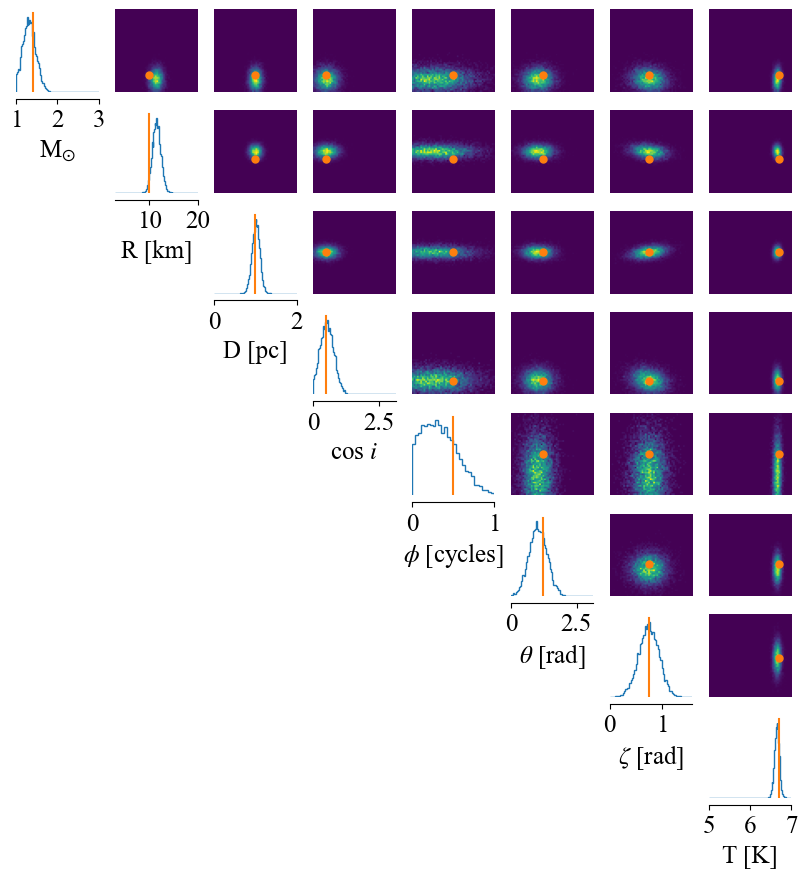

In [ ]:
p = [1.4,  # mass
     10,   # radius
     1.0,  # distance
     math.cos(np.radians(60)),  # inclination
     0.5,  # phase shift
     np.radians(70),  # super colatitude
     0.75, # super radius
     6.7]  # super temperature
test_observation = torch.Tensor(likelihood.synthesise(p, force=True, instr=instr_kwargs)).cuda() if torch.cuda.is_available() else (likelihood.synthesise(p, force=True, instr=instr_kwargs))

samples = posterior.sample((10000,), x=test_observation)

_ = analysis.pairplot(samples, 
                      limits=[[1, 3.0], [3, 20], [0.0, 2.0], [0.0, math.pi], [0.0, 1.0], [0.0, math.pi], [0.0, math.pi/2.0], [5.0, 7.0]], 
                      figsize=(10, 10),
                      points=np.array(p),
                      labels=[r'M$_{\odot}$', r'R [km]', r'D [pc]', r'cos $i$', r'$\phi$ [cycles]', r'$\theta$ [rad]', r'$\zeta$ [rad]', r'T [K]'])